# Dedicated Lane Simulation
In this notebook:
- We load our graph from a .gml file, complete with node and edge attributes.  
- We begin simulating the addition of a new network of dedicated fixed width lanes above our old one.  
- We study the characteristics of both networks, and their interplay

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import networkx as nx
import pdb

In [4]:
import os
cwd = os.getcwd()
graph_path = os.path.join(cwd, "dataset_vehicles_preprocessed/dataset_vehicles_preprocessed/road_graph.gml.gz")
G = nx.read_gml(graph_path)


## Adding preferential bus lanes to the network
We now want to create a new network that stems from our initial one. Our goal is to study this network and the underlying one's characteristics depending on two things: 
- the fractional size of the new network
- the width of the roads of the new network.  
NB these variables have some correlation: if i implement lanes of width x, then only roads wider than x can have those lanes. therefore, the fraction of roads that can have lanes is capped.
a relevant resulting quantity is the size of the remaining network compared to its initial size. Once we get more realistic, we could put in boundaries for how large a lane can be, or how large the remaining space of the street should be.
Another resulting variable is the maximum possible subnetwork size, which depends on our fractional size and width threshold.
possible further analyses may include implementing OPC as a preliminary congestion study.

In [6]:
Gcc = sorted(nx.connected_components(G), key = len, reverse = True)
G = G.subgraph(Gcc[0])
G = G.copy() #this way i can manipulate graph attributes without ruining original

In [7]:
def dedicated_lanes(G, width, greedy, fraction = 1, w_car = 3.5):
    #takes graph as input, creates dedicated lane networks with width parameter = max_width, and size = fraction*max_size(G)
    #where max_size(G) is the maximum size of the new network given its width parameter 
    #e.g if width = 5 i can't have an edge where the original network had an edge of width < 5
    #If greedy = True then bus lanes have priority over car lane survival
    
    G = G.copy() #so original network can be preserved 

    #CREATING SUBGRAPH
    #select region where we could make subgraph with edge_weights = width
    threshold = width+w_car
    if greedy:
        threshold = width
    G_ = nx.MultiGraph((source, target, attr) for source, target, attr in G.edges(data=True) if attr['weight'] > threshold)
    #update position attributes
    pos_dict = nx.get_node_attributes(G,'position') #dict of OLD graph attributes
    pos_dict = {key: value for key, value in pos_dict.items() if key in list(G_.nodes())} #remove keys that are not in NEW graph
    nx.set_node_attributes(G_,pos_dict,'position')
    nx.set_edge_attributes(G_,width, 'weight')
    #UPDATING ORIGINAL GRAPH WEIGHTS
    weight_dict = nx.get_edge_attributes(G,'weight')
    weight_dict2 = nx.get_edge_attributes(G_,'weight')
    for key in weight_dict2:
        if key in weight_dict.keys():
            weight_dict[key] -= width
    
    #weight_dict = {key: value - width for key, value in weight_dict.items()}
    nx.set_edge_attributes(G,weight_dict,'weight')
    if greedy == True: #remove car lanes that are too small to have cars
        temp = nx.MultiGraph((source, target, attr) for source, target, attr in G.edges(data=True) if attr['weight'] > w_car)
        pos_dict = nx.get_node_attributes(G,'position') #dict of OLD graph attributes
        pos_dict = {key: value for key, value in pos_dict.items() if key in list(temp.nodes())} #remove keys that are not in NEW graph
        nx.set_node_attributes(temp,pos_dict,'position')
        G = temp.copy()
        # edges_to_remove = [(u, v) for u, v, weight in G.edges(data='weight') if weight < w_car]
        # pdb.set_trace()
        # G.remove_edges_from(edges_to_remove)
        # print(len(G.edges))
    return G, G_

In [8]:
temp1, temp2 = dedicated_lanes(G,13, greedy = True)

In [9]:
def plot_comparison(G1, G2):
    #plots edges of base network G1 in black
    positions1 = nx.get_node_attributes(G1, 'position')
    positions2 = nx.get_node_attributes(G2, 'position')
    f, ax = plt.subplots(1, 1, figsize=(16, 16))
    threshold = list(nx.get_edge_attributes(G2,'weight').values())[0]
    plt.title(f"Comparison of base network vs clusters of dedicated lane network.\n width threshold = {threshold} m")
    ax.axis("off")
    nx.draw_networkx_edges(G1, positions1, ax = ax, edge_color = 'gray', width = 0.9, label = 'base network')
    #nx.draw_networkx_edges(G2, positions2, ax = ax, edge_color = 'green', width = 0.9, label = 'dedicated lane network')
    
    #draw dedicated lane network coloring by cluster
    colorlist = [ 'r', 'g', 'b', 'y', 'orange']
    Gcc = sorted(nx.connected_components(G2), key = len, reverse = True)
    for i in range(0, len(Gcc)):
        temp = G2.subgraph(Gcc[i])
        nx.draw_networkx_edges(G2, positions2, edgelist = list(temp.edges()), 
                               edge_color = colorlist[i%5], ax=ax)
    
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    plt.legend()
    #plt.colorbar
    #plt.savefig('network_comparison.png')
    plt.show()
    #labels = nx.draw_networkx_labels(G, pos=positions, font_size = 6)

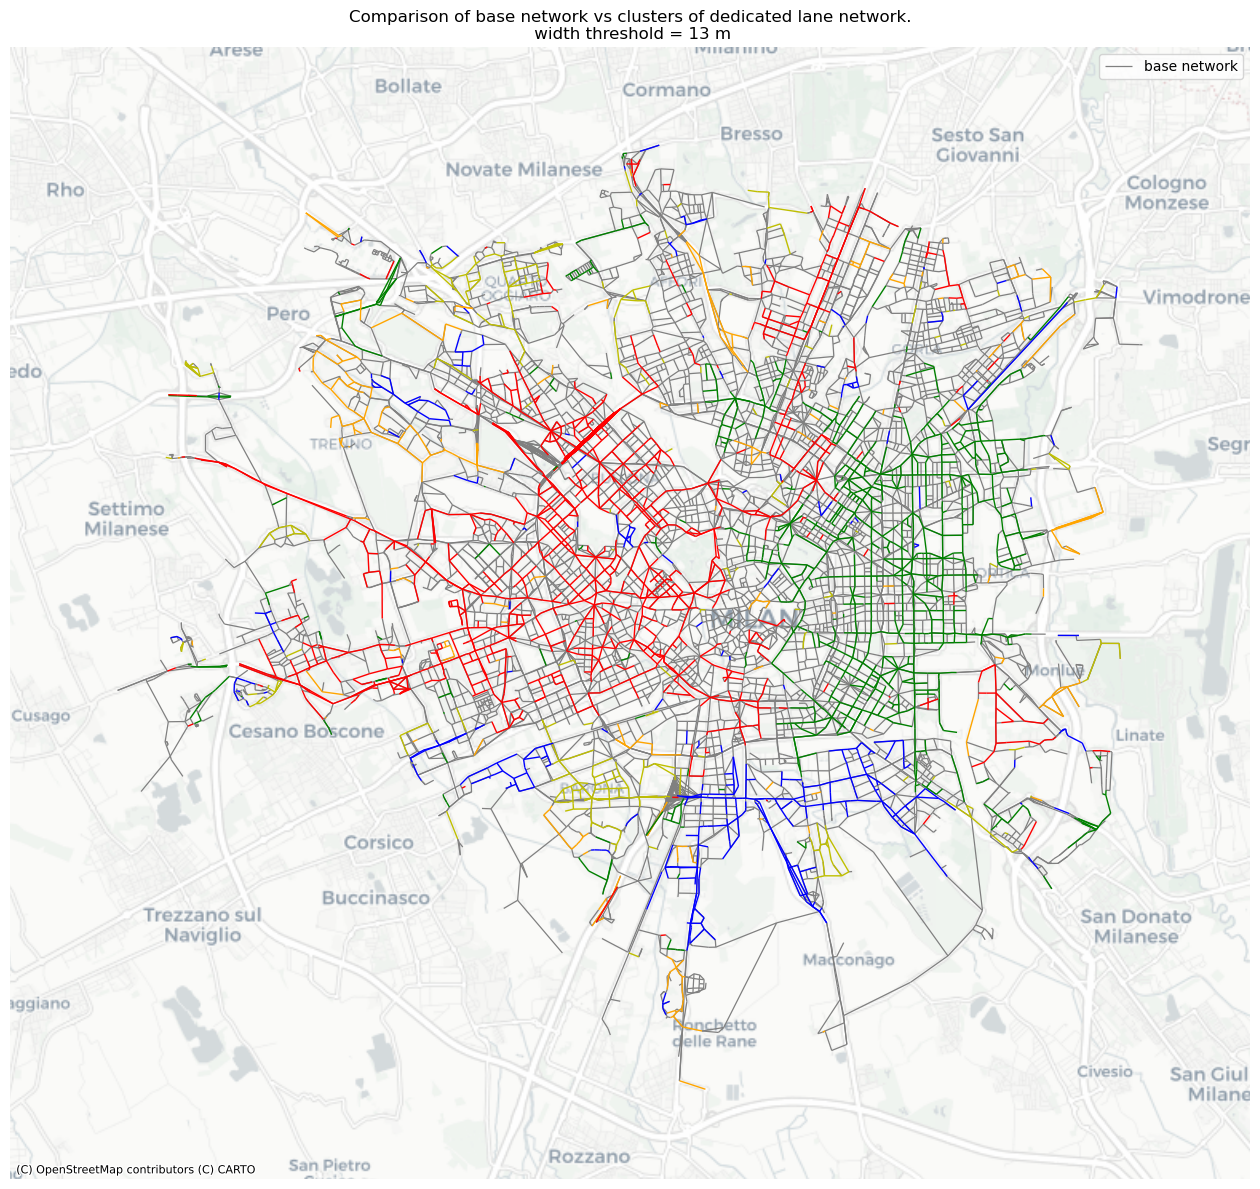

In [10]:
plot_comparison(temp1,temp2)

In [ ]:
sizes = pd.DataFrame(columns = ['base', 'car', 'bus', 'width threshold'])
for split in [4,6,7,8,9,10,11,12,14,16,18,20]:
    fig, axes = plt.subplots(1,2, figsize=(16,8))
    G1, G2 = dedicated_lanes(G, split, greedy = True, w_car = 3.5)
    #first ax
    positions1 = nx.get_node_attributes(G1, 'position')
    fig.suptitle(f"car network vs bus network")
    ax = axes[0]
    ax.axis("off")
    ax.set_title(f'car network. threshold = {split} m')
    edges, weights = zip(*nx.get_edge_attributes(G1,'weight').items())
    drawing1 = nx.draw_networkx_edges(G1, positions, edge_color = weights, 
                           edge_cmap = plt.cm.inferno, 
                           edge_vmin = min(weights)+2, edge_vmax = max(weights)-10, width =0.7,
                           node_size = 0.9,
                           ax = ax) 
    cbar = plt.colorbar(drawing1)
    cbar.set_label(f'Edge width (m)')
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    plt.colorbar

    #second ax
    positions2 = nx.get_node_attributes(G2, 'position')
    ax = axes[1]
    ax.set_title(f'bus network. edge width = {split} m')
    edges, weights = zip(*nx.get_edge_attributes(G2,'weight').items())
    drawing2 = nx.draw_networkx_edges(G2, positions, edge_color = 'b', 
                                      width =0.7, node_size = 0.9, ax = ax) 
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)


    plt.savefig(f'car_vs_bus_{split}m.png')
    temp_sizes = {'base': [len(G)],
                               'car':[len(G1)/len(G)],
                               'bus':[len(G2)/len(G)],
                              'width threshold':[split]}
    temp_sizes = pd.DataFrame(temp_sizes)
    sizes = pd.concat([sizes if not sizes.empty 
                               else None,temp_sizes], ignore_index = True)
#size plot
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title('size of networks compared to base network size')
ax2 = ax.twinx()
ax.set_ylabel('car network size')
ax.set_xlabel('width threshold')
ax2.set_ylabel('bus network size')
ax.plot(sizes['width threshold'], sizes['car'], color = 'red', label = 'car network', marker = 'o')
ax2.plot(sizes['width threshold'], sizes['bus'], color = 'blue', label = 'bus network', marker = 'o')
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
plt.legend(handles, labels)
plt.savefig('car_vs_bus_size_comparison.png')

the car network seems to suffer initially, then reform back. it also seems fairly resilient. i could plot the fractional size vs the width threshold.